## News articles category classification

The main purpose of this task is to help the executives in the organization who have limited time to know about the things going around the world in a shorter and condensed way. As one of the business executives in an e-commerce organization, I would be interested to know about facts in the following areas, <br>
* Business
* Politics
* Entertainment
* Tech
* Sports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
%matplotlib inline

In [2]:
categories = os.listdir("Data/BBC_News_Summary/News_Articles/")
categories.sort()
print(categories)

['business', 'entertainment', 'politics', 'sport', 'tech']


In [3]:
# Reading articles
articles = []
category = []
for newsType in categories:
    files = os.listdir("Data/BBC_News_Summary/News_Articles/"+newsType)
    for file in files:
        with open("Data/BBC_News_Summary/News_Articles/"+newsType+"/"+file,"r",encoding='utf-8',errors='ignore') as source:
            data = source.read().strip().splitlines()
        articles.append(" ".join(data))
        category.append(newsType)
article_dict = {"articles":articles,"category":category}
news_category_data = pd.DataFrame.from_dict(article_dict)
news_category_data.head(10)

,articles,category
0,UK economy facing 'major risks' The UK manufa...,business
1,Aids and climate top Davos agenda Climate cha...,business
2,Asian quake hits European shares Shares in Eu...,business
3,India power shares jump on debut Shares in In...,business
4,Lacroix label bought by US firm Luxury goods ...,business
5,Insurance bosses plead guilty Another three U...,business
6,Turkey-Iran mobile deal 'at risk' Turkey's in...,business
7,"Parmalat to return to stockmarket Parmalat, t...",business
8,WorldCom director admits lying The former chi...,business
9,Ebbers denies WorldCom fraud Former WorldCom ...,business


In [4]:
categories = sorted(news_category_data['category'].unique())
print(categories)

['business', 'entertainment', 'politics', 'sport', 'tech']


### Visualization

In [5]:
def visualize_categories(data,x,y):
    plt.figure(figsize=(x,y))
    data.value_counts().sort_values(ascending=False).plot(kind='barh')
    plt.xlabel("Categories")
    plt.ylabel("Count")
    plt.title("News Categories")

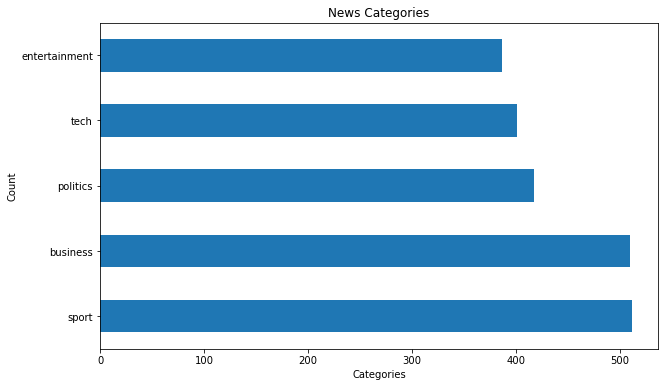

In [6]:
visualize_categories(news_category_data['category'],10,6)

From the above visualization, we can see three things, <br>
* Most of the news texts belong to the class "sport" and "business".
* The given dataset is slightly imbalanced.

### Data pre-processing and splitting data into train and test

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lawrence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
STOPWORDS = set(stopwords.words('english'))
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")

def remove_punctuations(text):
    no_punct = ""
    for char in text:
        if char not in punct:
            no_punct = no_punct + char
    return no_punct

In [9]:
def cleaned_sent(data):
    cleaned_text = []
    for sentences in data:
        encoding = sentences.encode("ascii","ignore")
        sent = encoding.decode().split()
        cleaned_Sent = [text.lower() for text in sent]
        cleaned_Sent = [contractions.fix(text) for text in cleaned_Sent]
        cleaned_Sent = [remove_punctuations(text) for text in cleaned_Sent]
        cleaned_Sent = [text for text in cleaned_Sent if(text.isalpha())]
        cleaned_Sent = [text for text in cleaned_Sent if text not in STOPWORDS]
        cleaned_Sent = " ".join(cleaned_Sent)
        cleaned_text.append(cleaned_Sent)
    return cleaned_text

In [10]:
cleaned_desc = cleaned_sent(news_category_data['articles'])
print(len(cleaned_sent(news_category_data['articles']))) #2225
print(len(news_category_data['category'].values)) #2225

2225
2225


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_desc)
print(len(vectorizer.vocabulary_))

29860


In [12]:
from sklearn.model_selection import train_test_split
x = cleaned_desc # the features we want to analyze
y = news_category_data['category'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Baseline

In [13]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

predicted_train_dummy = dummy_clf.predict(X_train)
print('We got an accuracy of train data using dummy classifier: ',round(np.mean(predicted_train_dummy == y_train)*100,2))

predicted_test_dummy = dummy_clf.predict(X_test)
print('We got an accuracy of test data using dummy classifier: ',round(np.mean(predicted_test_dummy == y_test)*100,2))

We got an accuracy of train data using dummy classifier:  20.67
We got an accuracy of test data using dummy classifier:  20.22


In [14]:
from sklearn.dummy import DummyClassifier
dummy_clf_2 = DummyClassifier(strategy="most_frequent")
dummy_clf_2.fit(X_train, y_train)

predicted_train_dummy_2 = dummy_clf_2.predict(X_train)
print('We got an accuracy of train data using dummy classifier: ',round(np.mean(predicted_train_dummy_2 == y_train)*100,2))

predicted_test_dummy_2 = dummy_clf_2.predict(X_test)
print('We got an accuracy of test data using dummy classifier: ',round(np.mean(predicted_test_dummy_2 == y_test)*100,2))

We got an accuracy of train data using dummy classifier:  23.6
We got an accuracy of test data using dummy classifier:  20.22


### Keras - Bi-LSTM model

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint
from pickle import load,dump
import pickle
from keras.models import Model, load_model

#### Setting Hyperparameters

In [16]:
vocab_size = 50000 # make the top list of words (common words)
embedding_dim = 64
max_length = 2000
truncate_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#### Tokenization

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
dump(tokenizer, open('Data/tokenizer.p', 'wb'))
word_index = tokenizer.word_index

#### Converting to Sequence

In [18]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

#### Sequence = Truncation + Padding

In [19]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, 
                               truncating=truncate_type)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding=padding_type, 
                               truncating=truncate_type)

#### Label Encoding

In [20]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(categories)

y_train_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [21]:
label_tokenizer.word_index

{'business': 1, 'entertainment': 2, 'politics': 3, 'sport': 4, 'tech': 5}

#### Model construction, training and evaluation

In [22]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          3200000   
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 3,266,822
Trainable params: 3,266,822
Non-trainable params: 0
_________________________________________________________________


In [23]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [24]:
num_epochs = 10
filepath = 'Models/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train_padded, y_train_label_seq, epochs=num_epochs,callbacks=[checkpoint], validation_data=(X_test_padded, y_test_label_seq), verbose=2)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.25558, saving model to Models/model-ep001-loss1.601-val_loss1.256.h5
56/56 - 50s - loss: 1.6007 - accuracy: 0.3174 - val_loss: 1.2556 - val_accuracy: 0.4562
Epoch 2/10

Epoch 00002: val_loss improved from 1.25558 to 0.75375, saving model to Models/model-ep002-loss0.985-val_loss0.754.h5
56/56 - 47s - loss: 0.9852 - accuracy: 0.5680 - val_loss: 0.7537 - val_accuracy: 0.6764
Epoch 3/10

Epoch 00003: val_loss improved from 0.75375 to 0.51385, saving model to Models/model-ep003-loss0.575-val_loss0.514.h5
56/56 - 52s - loss: 0.5754 - accuracy: 0.8022 - val_loss: 0.5139 - val_accuracy: 0.8449
Epoch 4/10

Epoch 00004: val_loss improved from 0.51385 to 0.42321, saving model to Models/model-ep004-loss0.224-val_loss0.423.h5
56/56 - 52s - loss: 0.2240 - accuracy: 0.9472 - val_loss: 0.4232 - val_accuracy: 0.8899
Epoch 5/10

Epoch 00005: val_loss improved from 0.42321 to 0.26481, saving model to Models/model-ep005-loss0.110-val_loss0.265.h5
56

#### Graphical representation of loss and accuracy

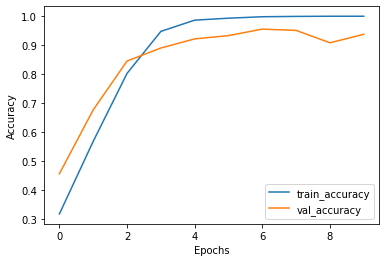

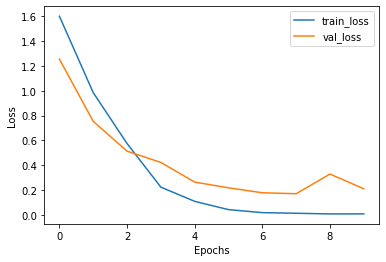

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(["train_accuracy", 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(["train_loss", 'val_loss'])
plt.show()

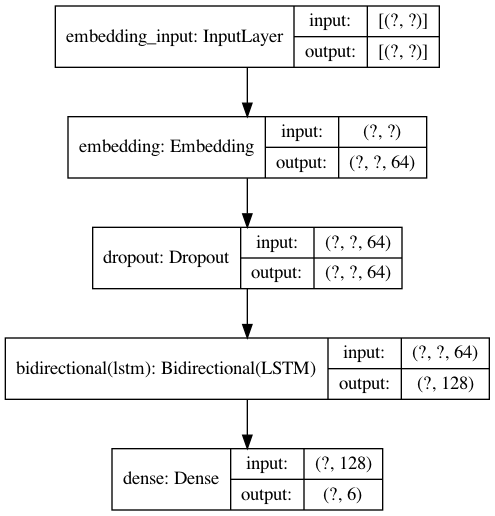

In [26]:
from keras.models import load_model
import visualkeras
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='Outputs/model_plot.png', show_shapes=True, show_layer_names=True)

#### Evaluation

In [27]:
#Source : https://edition.cnn.com/2020/12/16/tech/spotify-gaming-league-of-legends/index.html
text = ["""One of the undisputed winners of 2020's work-from-home transition has been Spotify, and it's not just because of all the new Taylor Swift albums and addictive true-crime podcasts.
As the streaming platform looks back on the biggest trends of 2020, one thing is certain: people are playing lots and lots of video games.
People streamed music from their gaming consoles 55% more this year compared to last year, Spotify told CNN Business.
"This year was unlike [any] before and as people started to social distance, users were looking for ways to stay connected with each other virtually," said Shanon Cook, Spotify's head of global culture and trends. "Gaming seemed to be something that provided that feeling of connectivity, while also passing time at home."
It's hardly a surprise that streaming is up across the board, but Spotify told CNN Business there were some unexpected trends this year.
Gamers tuned in early. The music streamed on gaming consoles between the hours of 6 am and 9mam rose 47% from last year. Their preferred genre? Mostly rap and trap music. The top songs streamed on gaming consoles included "The Box" by Roddy Ricch, "Blueberry Faygo" by Lil Mosey, "goosebumps" by rapper Travis Scott, "ROCKSTAR" by DaBaby feat. Roddy Ricch and "Falling" by Trevor Daniel.
Spotify traffic for Travis Scott, who has deals with McDonalds, PlayStation and Fortnite, skyrocketed after he performed a virtual concert inside Fortnite. The streaming platform noted streams increased 207% worldwide between April 26 and April 30 compared to the same period last year.
People actually sought out video game music. The most popular video game soundtracks this year were from "Minecraft,"the original "Doom" and "Death Stranding."""]
cleaned_test_data = cleaned_sent(text)
print(len(cleaned_test_data))

1


In [28]:
cleaned_test_data

['one undisputed winners workfromhome transition spotify new taylor swift albums addictive truecrime podcasts streaming platform looks back biggest trends one thing certain people playing lots lots video games people streamed music gaming consoles year compared last year spotify told cnn business year unlike people started social distance users looking ways stay connected virtually said shanon cook head global culture trends gaming seemed something provided feeling connectivity also passing time home hardly surprise streaming across board spotify told cnn business unexpected trends year gamers tuned early music streamed gaming consoles hours rose last year preferred genre mostly rap trap music top songs streamed gaming consoles included box roddy ricch blueberry faygo lil mosey goosebumps rapper travis scott rockstar dababy feat roddy ricch falling trevor daniel spotify traffic travis scott deals mcdonalds playstation fortnite skyrocketed performed virtual concert inside fortnite strea

In [29]:
saved_tokenizer = load(open("Data/tokenizer.p","rb"))
loaded_model = load_model("Models/model-ep008-loss0.014-val_loss0.171.h5")
sentence_seq = saved_tokenizer.texts_to_sequences(cleaned_test_data)
padded_sent = pad_sequences(sentence_seq, maxlen=max_length,padding=padding_type, 
                               truncating=truncate_type)
pred_category = loaded_model.predict(padded_sent)
print(np.argmax(pred_category)-1)
print(categories[np.argmax(pred_category)-1])

4
tech


Given text from CNN tech is predicted and belong to class "tech"

In [30]:
pred_news_category = []
for articles in X_test:
    cleaned_test_data = cleaned_sent([articles])
    sentence_seq = saved_tokenizer.texts_to_sequences(cleaned_test_data)
    padded_sent = pad_sequences(sentence_seq, maxlen=max_length,padding=padding_type, truncating=truncate_type)
    pred_news_category.append(categories[np.argmax(loaded_model.predict(padded_sent))-1])
len(pred_news_category)

445

In [31]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("Precision Score :",round(precision_score(y_test,pred_news_category,average='weighted'),3))
print("Recall Score :",round(recall_score(y_test,pred_news_category,average='weighted'),3))
print("F1 Score :",round(f1_score(y_test,pred_news_category,average='weighted'),3))

Precision Score : 0.952
Recall Score : 0.951
F1 Score : 0.951
